In [ ]:
def nom_MCA(df,y=None,n_=None):
    nom_ohe = OneHotEncoder(sparse=False,categories=nominal_categories(df))
    enc_mat = nom_ohe.fit_transform(df.astype('int'))
    features_out = nom_ohe.get_feature_names_out()
    df_enc = pd.DataFrame(enc_mat,columns=features_out)
    # enc_df = df_enc
    nvc = nominal_value_counts()
    for c in df_enc:
        stub = c.split('_')
        unique_category = int(stub[-1])
        # print(unique_category)
        suffix_len = 1+len(str(unique_category))
        feature = c[:-suffix_len]
        unique_category_count = nvc[feature][unique_category]
        # print(unique_category_count)
        df_enc.loc[:,c] = (df_enc.loc[:,c]/(unique_category_count/nominal_data.shape[0])) - 1
    dime = PCA()
    if n_:
        dime = PCA(n_components=n_,svd_solver='full',random_state=42)
    final_nome_t  = dime.fit_transform(df_enc)
    return final_nome_t
    
    
def ord_MCA(df,y=None,n_=None):
    ord_ohe = OneHotEncoder(sparse=False,categories=ordinal_categories(df))
    enc_mat = ord_ohe.fit_transform(df.astype('int'))
    features_out = ord_ohe.get_feature_names_out()
    df_enc = pd.DataFrame(enc_mat,columns=features_out)
    # enc_df = df_enc
    ovc = ordinal_value_counts()
    for c in df_enc:
        stub = c.split('_')
        unique_category = int(stub[-1])
        # print(unique_category)
        suffix_len = 1+len(str(unique_category))
        feature = c[:-suffix_len]
        unique_category_count = ovc[feature][unique_category]
        # print(unique_category_count)
        df_enc.loc[:,c] = (df_enc.loc[:,c]/(unique_category_count/ordinal_data.shape[0])) - 1
    dime = PCA()
    if n_:
        dime = PCA(n_components=n_,svd_solver='full',random_state=42)
    final_nome_t  = dime.fit_transform(df_enc)
    return final_nome_t


ordinal_mca = FunctionTransformer(ord_MCA,kw_args={'n_':None})
nominal_mca = FunctionTransformer(nom_MCA,kw_args={'n_':None})

In [185]:
3796/1628


2.3316953316953315

In [222]:
X_dn.nominal__v_21.value_counts()

3.0     2801
4.0      333
8.0       77
10.0      75
6.0       75
5.0       72
12.0      70
11.0      66
7.0       64
9.0       63
33.0      57
1.0       43
Name: nominal__v_21, dtype: int64

93

In [121]:
vc_train = {x:raw_data[x].value_counts().to_dict() for x in nominal}


In [122]:
def mark_infreq_nom(row):
    for c in nominal:
        if row[c] in selected_infreq[c]:
            row[c] = infreq_slot[c]
    return row


In [216]:
raw_data.loc[:,nominal].nunique()

nominal__v_12     37
nominal__v_18     95
nominal__v_20     98
nominal__v_21     22
nominal__v_25     80
nominal__v_3     124
nominal__v_32     84
nominal__v_4      98
dtype: int64

In [124]:
raw_master = pd.concat([raw_data.loc[:,raw_data_eval.columns],raw_data_eval],ignore_index=True,axis=0)
vc_master = {x:raw_master[x].value_counts().to_dict() for x in nominal}
vc_train = {x:raw_data[x].value_counts().to_dict() for x in nominal}
vc_eval = {x:raw_data_eval[x].value_counts().to_dict() for x in nominal}


def count_encode(row):
    for c in nominal:
        key = row[c]
        new_key = vc_master[c][key]
        row[c] = new_key
    return row

raw_master_ = raw_master.copy()
raw_data_ = raw_data.copy()
raw_data_eval_ = raw_data_eval.copy()
raw_data_.loc[:,nominal]=raw_data.loc[:,nominal].apply(count_encode,axis=1).astype('int')
raw_master_.loc[:,nominal]=raw_master.loc[:,nominal].apply(count_encode,axis=1).astype('int')
raw_data_eval_.loc[:,nominal]=raw_data_eval.loc[:,nominal].apply(count_encode,axis=1).astype('int')

def ordinal_encode_nominal(raw_master_,raw_data_,raw_data_eval_):
    ordinal_enc = OrdinalEncoder()
    ordinal_enc.fit(raw_master_.loc[:,nominal])
    raw_data_enc = ordinal_enc.transform(raw_data_.loc[:,nominal])
    raw_data_eval_enc = ordinal_enc.transform(raw_data_eval_.loc[:,nominal])
    raw_data_.loc[:,nominal] = raw_data_enc.astype('int')
    raw_data_eval_.loc[:,nominal] = raw_data_eval_enc.astype('int')
    return raw_master_,raw_data_,raw_data_eval_


# raw_master_,raw_data_,raw_data_eval_ = ordinal_encode_nominal(raw_master_,raw_data_,raw_data_eval_)

In [11]:
nominal_ohe_df = pd.get_dummies(raw_data.loc[:,nominal],columns=nominal,drop_first=False)
nominal_count_ohe_df = pd.get_dummies(raw_data_.loc[:,nominal],columns=nominal,drop_first=False)

In [110]:
# raw_data_.loc[:,nominal]/5424
class_labels = [0,1,2]
vc_i = {x:{} for x in range(3)}
for cl in class_labels:
    cp = raw_data[raw_data.target==cl]
    cn = raw_data[raw_data.target!=cl]
    vc_p = {x:{} for x in nominal }
    vc_n = {x:{} for x in nominal }
    for c in nominal:
        vc_p[c] = cp[c].value_counts().to_dict()        
        vc_n[c] = cn[c].value_counts().to_dict()
    vc_i[cl]['p'] = vc_p
    vc_i[cl]['n'] = vc_n
raw_data.target.value_counts()
N = raw_data.shape[0]
Np_Nn = {1:(1863,N-1863),2:(690,N-690),0:(1243,N-1243)}
for cl in vc_i:
    Np , Nn = Np_Nn[cl]
    # vc_i[cl]['p']
    for c in vc_i[cl]['p']:
        for k in vc_i[cl]['p'][c]:
            vc_i[cl]['p'][c][k] = vc_i[cl]['p'][c][k]/vc_train[c][k]
        for k in vc_i[cl]['n'][c]:
            vc_i[cl]['n'][c][k] = vc_i[cl]['n'][c][k]/vc_train[c][k]    
            
# for cl in vc_i:
positive = {cl: vc_i[cl]['p'] for cl in vc_i}    
negative = {cl: vc_i[cl]['n'] for cl in vc_i}    
#  = vc_i[cl]['n']


In [228]:
cramer(raw_data,nominal)

nominal__v_12    0.01
nominal__v_18    0.05
nominal__v_20    0.05
nominal__v_21    0.01
nominal__v_25    0.04
nominal__v_3     0.05
nominal__v_32    0.07
nominal__v_4     0.08
Name: target, dtype: float64

In [43]:
j_ohe = {x:sklearn.neighbors. for x in nominal_ohe.columns}
j_ohe1 = {x:0 for x in nominal_count_ohe.columns}

In [49]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))
y = raw_data.target
# cramers_v(nominal_ohe,y)
j_ohe = {x:cramers_v(nominal_ohe[x],y) for x in nominal_ohe.columns}
j_ohe1 = {x:cramers_v(nominal_count_ohe[x],y) for x in nominal_count_ohe.columns}

In [55]:
pd.Series(j_ohe,index = nominal_ohe.columns).sort_values(ascending=False)
pd.Series(j_ohe1,index = nominal_ohe.columns).sort_values(ascending=False)

nominal__v_32_36    0.201769
nominal__v_32_38    0.179628
nominal__v_4_39     0.166739
nominal__v_4_26     0.153747
nominal__v_25_33    0.147906
                      ...   
nominal__v_4_93          NaN
nominal__v_4_94          NaN
nominal__v_4_95          NaN
nominal__v_4_96          NaN
nominal__v_4_97          NaN
Length: 638, dtype: float64

In [ ]:
from sklearn.manifold import *

kpca_cols  = make_column_selector(pattern='binary__*|nominal__*|ordinal__*|bin_*|ord_*')
ohe_cols = make_column_selector(pattern='nominal__*')

kernel_pca = KernelPCA(kernel='cosine',random_state=42,eigen_solver='dense',n_jobs=-1,fit_inverse_transform=False)
isomap = Isomap(n_components=2,eigen_solver='dense',n_jobs=-1,)
embedding = LocallyLinearEmbedding(n_jobs=-1,random_state=42,max_iter=1000,n_neighbors=100,method='modified')
"""
ColumnTransformer
"""

trf = ColumnTransformer([
    ('kernel_pca',OneHotEncoder(sparse=False),ohe_cols),
    ('stdscl',make_pipeline(StandardScaler()),make_column_selector(pattern='ratio__*'))
],sparse_threshold=0, remainder='passthrough',n_jobs=-1)
# embedding = Isomap()
iso_tf = make_pipeline(trf,embedding,memory=CACHE_)
X = raw_data.drop(['target'],axis=1)
y = raw_data.target
with parallel_backend('loky'):
    X_t = iso_tf.fit_transform(X)
# make_pipeline()

fig, ax = plt.subplots(1,1,figsize=(10,10))
disp = ax.scatter(X_t[:,0],X_t[:,1],c=y,cmap='plasma')

In [ ]:
# X= raw_data.drop(['target'],axis=1)
Q = pd.get_dummies(raw_data,columns=nominal+ordinal,drop_first=True,)
cols= Q.columns
s_cols = [c for c in cols if 'nominal' in c or 'ordinal' in c]
X = Q.loc[:, s_cols]
# X = nominal_data
# X = raw_data.loc[:,nominal+ordinal+binary+['bin_literal','ord_norm','binary_sum']+ratios]

y = raw_data.target
clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
clf.fit(X,y)
from sklearn import inspection
with parallel_backend('threading'):
    permutation_importance = inspection.permutation_importance(clf,X,y,scoring='f1_macro',random_state=42,n_jobs=-1,n_repeats=2)

imp_mean_pd = pd.Series(permutation_importance['importances_mean'],index=X.columns)
imp_std_pd = pd.Series(permutation_importance['importances_std'],index=X.columns)

importance = pd.DataFrame()
importance['mean'] = imp_mean_pd
importance['std'] = imp_std_pd
importance = importance.sort_values(by='mean',ascending=False)
importance[importance['mean']>0.004]
importance
f_ohe_cols = list(importance[importance['mean']>0.02].index)
X = Q.loc[:, f_ohe_cols]


f_ohe_cols = list(importance[importance['mean']>0.000001].index)
X = Q.loc[:, f_ohe_cols]

# X = Q.loc[:, f_ohe_cols]
y = raw_data.target
model = DecisionTreeClassifier(class_weight='balanced',random_state=42)
model = BernoulliNB(binarize=False,fit_prior=False,alpha=0.1234401)
model = LogisticRegressionCV(class_weight='balanced',max_iter=100000)
# pca = RFE(estimator=LogisticRegression(class_weight='balanced',max_iter=100000),n_features_to_select=250)
pca = PCA()
# model = RandomForestClassifier(random_state=42,class_weight='balanced_subsample')
clf = make_pipeline(pca,OneVsRestClassifier(model),memory=Memory(DATA_SAVE_PATH,verbose=0))
scores = cross_validate(clf,X,y,cv=RepeatedStratifiedKFold(n_splits=2,n_repeats=2),n_jobs=-1,scoring='f1_macro',return_train_score=True)
scores['test_score'].mean()

In [ ]:
X = raw_data.loc[:,high_variable_f[3]]
y = raw_data.target
X_train, X_test, y_train, y_test = gen_train_test(X,y, 0.2)
calibration = CalibratedClassifierCV(clf,cv=5,n_jobs=-1,ensemble=True,method='sigmoid')
calibration.fit(X_train,y_train)
clf.fit(X_train,y_train)
calibrated_pred = calibration.predict(X_test)
y_pred = clf.predict(X_test)
fig,ax = plt.subplots(2,1,figsize=(10,10))
plt.style.use('fivethirtyeight')
disp = ConfusionMatrixDisplay.from_predictions(y_test,calibrated_pred,ax=ax[0])
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,ax=ax[1])
# scores = cr(clf,X,y,cv=RepeatedStratifiedKFold(**FOLDS),n_jobs=-1,scoring='f1_macro',return_train_score=True)

print(classification_report(y_test,calibrated_pred))
print(classification_report(y_test,y_pred))

### Sort Columns by Alphabetical Order to group similar Data Types

In [10]:
@run_if_refresh
def sort_columns_by_name(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data = raw_data.sort_index(axis=1)
    raw_data_eval = raw_data_eval.sort_index(axis=1)
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")


sort_columns_by_name()

raw_data, raw_data_eval = reload_raw_data()

In [11]:
baseline(raw_data)

              precision    recall  f1-score   support

           0       0.82      0.61      0.70       497
           1       0.80      0.81      0.81       746
           2       0.42      0.60      0.49       276

    accuracy                           0.71      1519
   macro avg       0.68      0.67      0.67      1519
weighted avg       0.74      0.71      0.71      1519

F1_Train 0.9800700126137107
F1_Test 0.6793181849428934


### Ordinal Encoding all Nominal Categories to Reduce <br> Categorical distance and making them Uniform

In [12]:
# for c in nominal:
# print(sorted(raw_data[c].unique()))
nominal_data.nunique()

nominal__v_12     37
nominal__v_18     95
nominal__v_20     98
nominal__v_21     22
nominal__v_25     80
nominal__v_3     124
nominal__v_32     84
nominal__v_4      98
dtype: int64

In [13]:
@run_if_refresh
def ordinally_encode_nominal_data():
    ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=125)
    nominal_enc_data = ordinal_enc.fit_transform(raw_data.loc[:, nominal])
    nominal_enc_data_eval = ordinal_enc.transform(raw_data_eval.loc[:, nominal])
    raw_data.loc[:, nominal] = nominal_enc_data
    raw_data_eval.loc[:, nominal] = nominal_enc_data_eval
    write_raw_data(raw_data, raw_data_eval)


ordinally_encode_nominal_data()
raw_data, raw_data_eval = reload_raw_data()

In [14]:
baseline(raw_data)

              precision    recall  f1-score   support

           0       0.83      0.62      0.71       497
           1       0.80      0.81      0.80       746
           2       0.43      0.62      0.50       276

    accuracy                           0.71      1519
   macro avg       0.69      0.68      0.67      1519
weighted avg       0.74      0.71      0.72      1519

F1_Train 0.9792954494260291
F1_Test 0.6789753846355794


In [15]:
raw_data.describe()

,binary__v_1,binary__v_11,binary__v_14,binary__v_26,binary__v_27,binary__v_28,binary__v_30,binary__v_9,nominal__v_12,nominal__v_18,nominal__v_20,nominal__v_21,nominal__v_25,nominal__v_3,nominal__v_32,nominal__v_4,ordinal__v_0,ordinal__v_10,ordinal__v_13,ordinal__v_15,ordinal__v_17,ordinal__v_19,ordinal__v_22,ordinal__v_23,ordinal__v_24,ordinal__v_29,ordinal__v_31,ordinal__v_33,ordinal__v_5,ordinal__v_6,ratio__v_16,ratio__v_2,ratio__v_34,ratio__v_35,ratio__v_36,ratio__v_37,ratio__v_38,ratio__v_39,ratio__v_40,ratio__v_7,ratio__v_8,target
count,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.000000,3796.00000
mean,0.911486,0.466280,0.179399,0.262118,0.731560,0.040569,0.463646,0.374605,1.340885,30.722339,46.838514,1.250000,32.680717,43.471812,24.723656,45.106955,0.998156,7.064015,1.600896,2.609062,9.165701,5.562171,10.794521,0.975764,1.392255,11.162803,7.134089,7.127239,8.934932,5.281876,0.835901,2.041333,5.341149,50.674658,26.212065,20.837197,31.276607,40.210485,3.278978,12.394810,3.436249,0.85432
std,0.284079,0.498927,0.383737,0.439844,0.443206,0.197316,0.498742,0.484084,3.988022,18.378995,30.113549,2.969398,25.852215,21.430502,22.510376,25.413765,2.309686,3.079682,3.216409,2.576362,4.670733,3.757691,5.532030,2.249038,2.866872,5.213275,7.887596,3.256676,4.507494,3.674661,3.109413,2.516779,3.507388,29.330820,14.929649,11.984063,17.847942,22.466458,2.618851,3.414303,4.577644,0.69866
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.060000,-0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,1.000000,0.00000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,17.000000,0.000000,4.000000,28.000000,0.000000,18.000000,0.000000,6.000000,0.000000,1.000000,7.000000,4.000000,11.000000,0.000000,0.000000,11.000000,2.000000,6.000000,6.000000,3.000000,-1.700000,0.500000,3.000000,25.000000,13.000000,11.000000,16.000000,21.750000,1.000000,9.400000,1.000000,0.00000
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,25.000000,44.000000,0.000000,34.000000,44.000000,28.000000,46.000000,0.000000,6.000000,0.000000,1.000000,8.000000,6.000000,12.000000,0.000000,0.000000,12.000000,4.000000,6.000000,8.000000,5.000000,0.790000,1.400000,5.000000,50.000000,26.000000,21.000000,31.000000,41.000000,3.000000,12.400000,1.000000,1.00000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,48.000000,71.000000,1.000000,60.000000,61.000000,41.000000,67.000000,0.000000,8.000000,2.000000,3.000000,12.000000,7.000000,14.000000,0.000000,1.000000,14.000000,10.000000,8.000000,11.000000,7.000000,2.020000,2.800000,8.000000,76.000000,39.000000,31.000000,47.000000,59.000000,5.000000,14.900000,3.000000,1.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,36.000000,94.000000,97.000000,21.000000,79.000000,123.000000,83.000000,97.000000,14.000000,23.000000,24.000000,16.000000,45.000000,27.000000,25.000000,14.000000,22.000000,25.000000,53.000000,26.000000,33.000000,20.000000,12.510000,12.700000,18.000000,107.000000,58.000000,49.000000,69.000000,87.000000,14.000000,25.200000,25.000000,2.00000


### Using Sum of Binary Features

In [16]:
@run_if_refresh
def binary_feature_sum(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data["binary_sum"] = raw_data.loc[:, binary].sum(axis=1)
    raw_data_eval["binary_sum"] = raw_data_eval.loc[:, binary].sum(axis=1)
    write_raw_data(raw_data, raw_data_eval)


binary_feature_sum()
raw_data, raw_data_eval = reload_raw_data()

In [17]:
baseline(raw_data)

              precision    recall  f1-score   support

           0       0.83      0.61      0.70       497
           1       0.79      0.82      0.80       746
           2       0.42      0.59      0.50       276

    accuracy                           0.71      1519
   macro avg       0.68      0.67      0.67      1519
weighted avg       0.74      0.71      0.72      1519

F1_Train 0.9806183813393191
F1_Test 0.680800407426308


### Standardising Ratio Values

In [18]:
@run_if_refresh
def standardise_ratio_features(
    raw_data=raw_data.copy(), raw_data_eval=raw_data_eval.copy()
):
    # Load Data
    payload = raw_data.loc[:, ratios]
    payload_eval = raw_data_eval.loc[:, ratios]
    # Define Scaling Method
    scaler1 = QuantileTransformer(
        output_distribution="normal", random_state=42, n_quantiles=1000
    )
    scaler2 = KBinsDiscretizer(
        encode="onehot-dense", random_state=10, n_bins=3, strategy="kmeans"
    )
    # mscaler = make_pipeline(scaler1,scaler2)
    mscaler = StandardScaler()
    # Apply Scaling
    payload_t = mscaler.fit_transform(payload)
    payload_eval_t = mscaler.transform(payload_eval)
    # New Column Names
    new_ordinal_col_names = mscaler.get_feature_names_out()
    new_ordinal_col_names = [x.replace(".", "_") for x in new_ordinal_col_names]
    # Create Dataframe with new features to concatenate
    tmp_raw_data = pd.DataFrame(
        payload_t, columns=new_ordinal_col_names, index=raw_data.index
    ).astype("int")
    tmp_raw_data_eval = pd.DataFrame(
        payload_eval_t, columns=new_ordinal_col_names, index=raw_data_eval.index
    ).astype("int")
    # Concatenate in place
    raw_data = pd.concat([tmp_raw_data, raw_data.drop(ratios, axis=1)], axis=1)
    raw_data_eval = pd.concat(
        [tmp_raw_data_eval, raw_data_eval.drop(ratios, axis=1)], axis=1
    )
    # Write modified data to disk
    write_raw_data(raw_data, raw_data_eval)
    # return raw_data


standardise_ratio_features()
raw_data, raw_data_eval = reload_raw_data()

In [19]:
baseline(raw_data)

              precision    recall  f1-score   support

           0       0.85      0.62      0.72       497
           1       0.81      0.82      0.81       746
           2       0.43      0.62      0.51       276

    accuracy                           0.72      1519
   macro avg       0.69      0.69      0.68      1519
weighted avg       0.75      0.72      0.73      1519

F1_Train 0.9730306132586725
F1_Test 0.6852330197510701


In [20]:
baseline(raw_data.loc[:, nominal + ["target"]])

              precision    recall  f1-score   support

           0       0.46      0.44      0.45       497
           1       0.62      0.49      0.55       746
           2       0.25      0.41      0.31       276

    accuracy                           0.46      1519
   macro avg       0.44      0.45      0.44      1519
weighted avg       0.50      0.46      0.47      1519

F1_Train 0.9011832457876175
F1_Test 0.43304228047789883


(3796, 77)


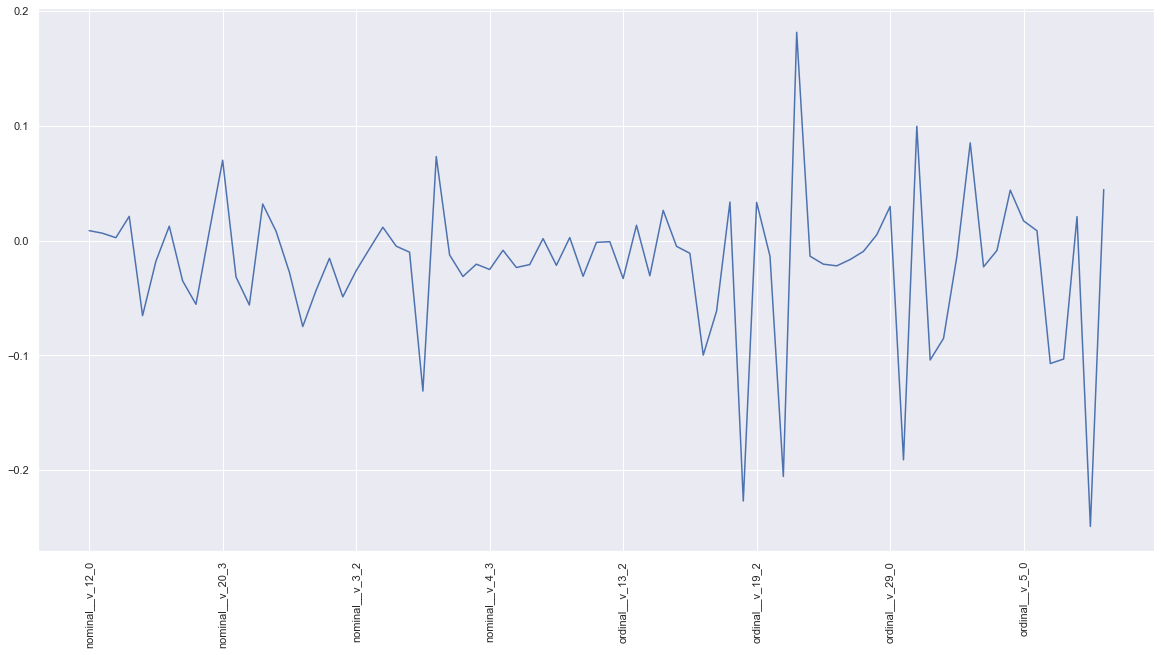

In [82]:
encoder = PolynomialWrapper(CountEncoder(normalize=True))
encoder = BaseNEncoder(base=3)
x_t = encoder.fit_transform(
    raw_data.loc[:, nominal + ordinal].astype("category"), raw_data.target
)
print(x_t.shape)
disp = x_t.corrwith(raw_data.target, method="kendall").plot(figsize=(20, 10), rot=90)

In [100]:
# encoder = PolynomialWrapper(BaseNEncoder(base=3))
encoder = BaseNEncoder(base=30)
n_features = encoder.fit_transform(X_train).shape[1]
tmp = make_pipeline(
    encoder,
    HistGradientBoostingClassifier(
        categorical_features=[True] * n_features, random_state=42
    ),
)
y_pred = tmp.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred, labels=[0, 1, 2]))

              precision    recall  f1-score   support

           0       0.73      0.64      0.68       373
           1       0.74      0.88      0.80       559
           2       0.43      0.30      0.35       207

    accuracy                           0.70      1139
   macro avg       0.63      0.61      0.61      1139
weighted avg       0.68      0.70      0.68      1139



In [167]:
n_feature_p = {}
n_score_p = {}
# encoder = BaseNEncoder(base=i)
X = raw_data.loc[:, nominal + ordinal].astype("category")
y = raw_data.target
X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.3)
X_train = X_train.astype("category")
X_test = X_test.astype("category")
n_score_p[0] = mutual_info_classif(X_test, y_test, discrete_features=True).mean()
n_feature_p[0] = X_train.shape[1]


def categorise_input(X: pd.DataFrame):
    return X.astype("category")


categoriser = FunctionTransformer(categorise_input, feature_names_out="one-to-one")
for i in range(2, 10, 1):
    encoder = make_pipeline(
        BaseNEncoder(base=i), categoriser, PolynomialWrapper(JamesSteinEncoder())
    )
    n_features = encoder.fit_transform(X_train, y_train).shape[1]
    # tmp =make_pipeline(encoder,HistGradientBoostingClassifier(categorical_features=[True]*n_features,random_state=42))
    # y_pred = tmp.fit(X_train, y_train).predict(X_test)
    # print(classification_report(y_test,y_pred,labels=[0,1,2]))
    X_train_enc = encoder.fit_transform(X_train, y_train)
    X_test_enc = encoder.transform(X_test)
    n_score_p[i] = mutual_info_classif(
        X_train_enc, y_train, discrete_features=True
    ).mean()
    n_feature_p[i] = n_features

In [168]:
(n_score_p, n_feature_p)

({0: 0.07689778640450684,
  2: 0.005022425791708347,
  3: 0.009250367606439108,
  4: 0.011197161357249899,
  5: 0.014092863795907207,
  6: 0.01588777618515198,
  7: 0.01614037551663018,
  8: 0.01854815599352313,
  9: 0.021927145899901815},
 {0: 22, 2: 357, 3: 231, 4: 204, 5: 165, 6: 153, 7: 150, 8: 147, 9: 138})

In [169]:
mutual_info_classif(X_train, y_train, discrete_features=True).mean()

0.06752700611223024

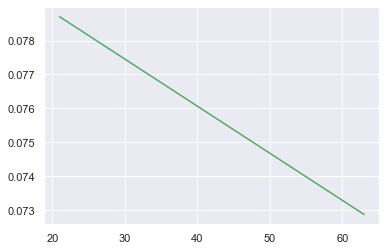

In [135]:
# plt.plot(n_feature_p.keys(),n_feature_p.values(),'-^r')
plt.plot(n_feature_p.values(), n_score_p.values(), "-g")

In [ ]:
dum = make_pipeline(categoriser, OneHotEncoder())
dum.fit_transform(X_train)

In [118]:
mutual_info_classif(X_train, y_train, discrete_features=True).mean()

0.06892922111251147

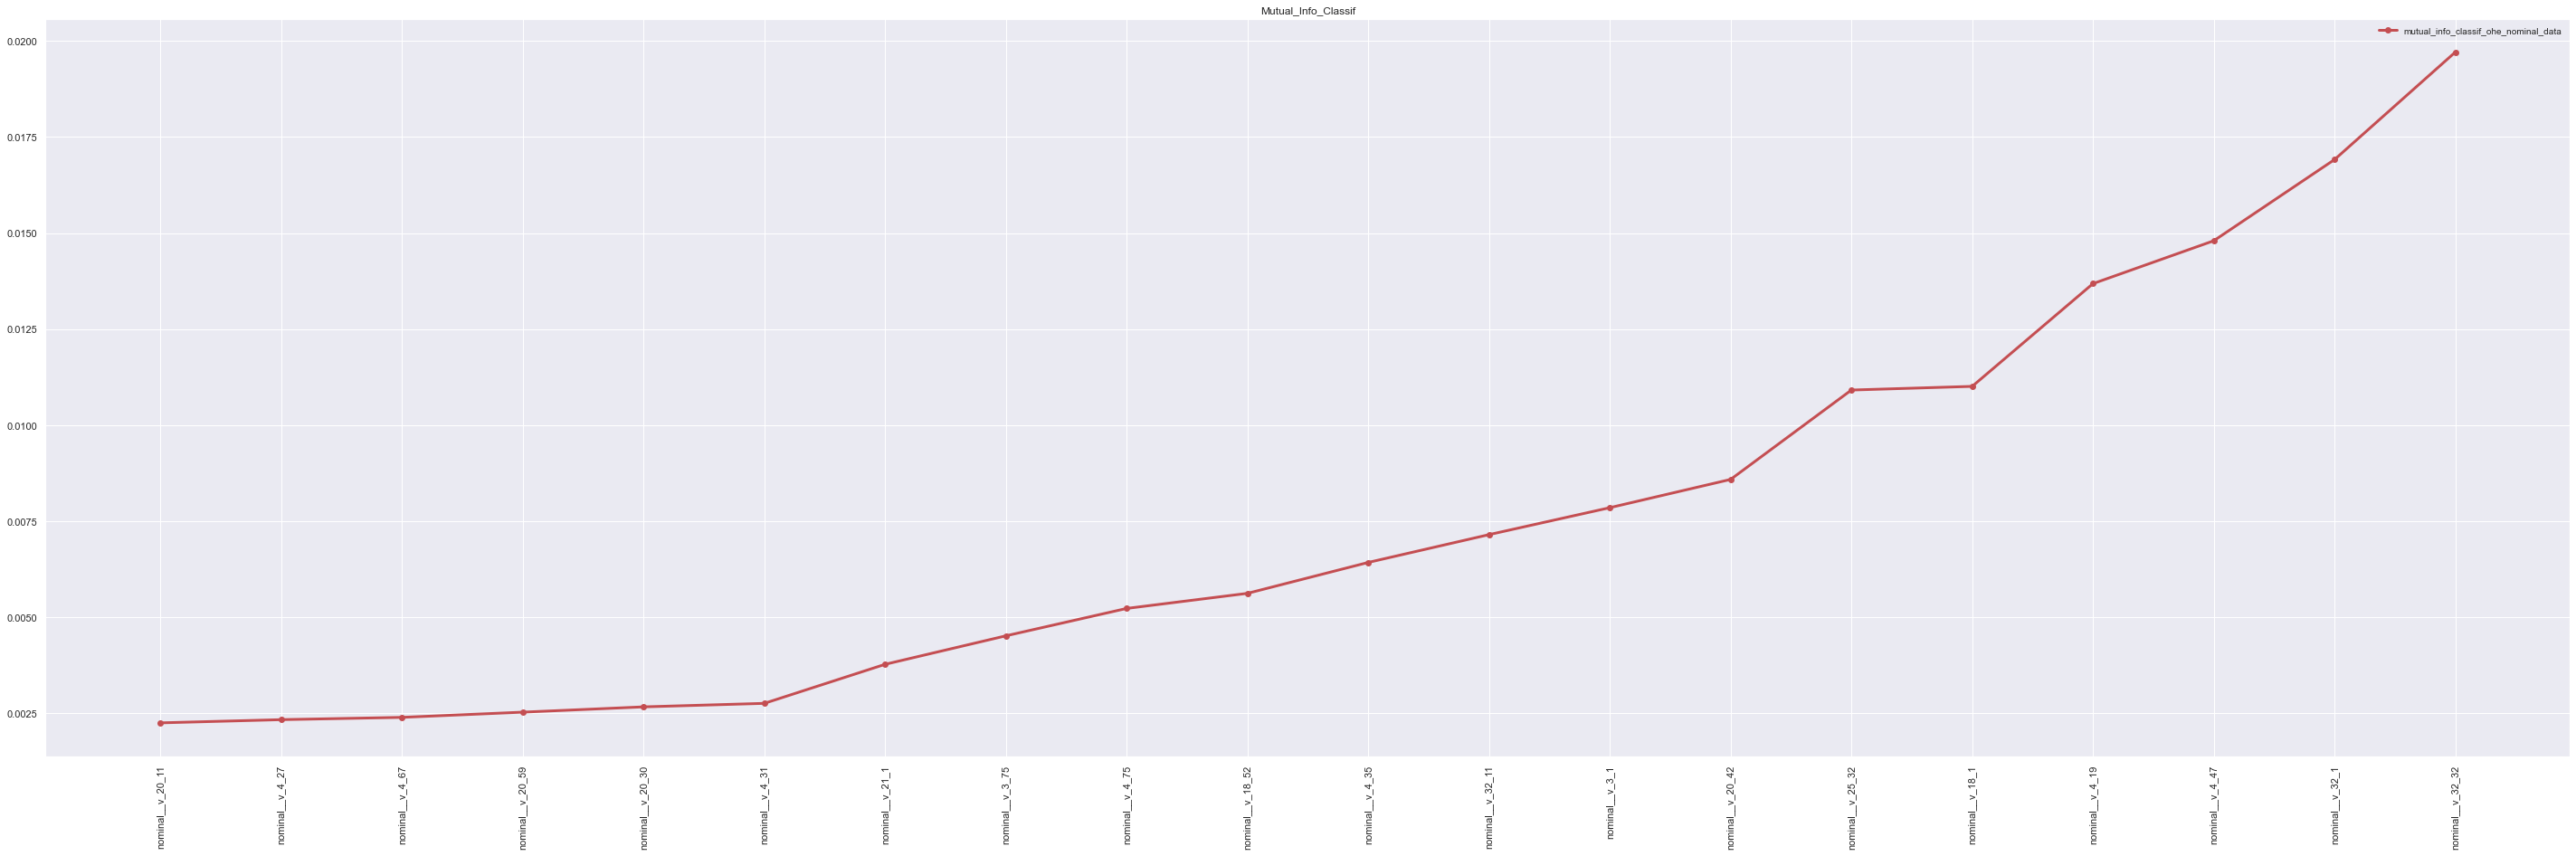

In [8]:
m_info_clf = mutual_info_classif(
    X=n1df, y=target, discrete_features=True, random_state=42
)
__featureOrder = m_info_clf.argsort()
fig, ax = plt.subplots(1, 1, figsize=(50, 15))
plt.style.use("seaborn")
plt.rcParams["font.size"] = 16
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["lines.linewidth"] = 3
plt.xticks(rotation=90)
ax.plot(
    n1df.columns[__featureOrder][-20:],
    m_info_clf[__featureOrder][-20:],
    "-ro",
    label="mutual_info_classif_ohe_nominal_data",
)
ax.legend()
disp = ax.set_title("Mutual_Info_Classif")

In [ ]:
scf = {"f_clf": f_classif, "chi2": chi2}
alpha_ = 0.12
k_best = 70
# class f_selection_party:
all_selectors = {}


def update_selectors(alpha_, k_best):
    global all_selectors
    for criterion, _scf in scf.items():
        selectors = [
            SelectFpr(
                chi2,
            ),
            SelectFdr(chi2),
            SelectFwe(chi2),
            SelectKBest(chi2, k=k_best),
            SelectFwe(chi2),
        ]
        for slctr in selectors:
            all_selectors[criterion + "-" + slctr.__class__.__name__] = slctr


update_selectors(alpha_=alpha_, k_best=k_best)
# feature_selection = Pipeline([("feature_selector", )])
feature_selection = FeatureUnion(
    transformer_list=list(all_selectors.items()), n_jobs=-1
)
feature_selection

In [ ]:
import plotly.express as px
import plotly.figure_factory as ff

m_info_clf = mutual_info_classif(
    X=n1df, y=target, discrete_features=True, random_state=42
)
f_info = dict(
    zip(
        n1df.columns,
        m_info_clf,
    )
)
micdf = pd.DataFrame(m_info_clf, columns=["M_I_C"], index=n1df.columns)
# px.histogram(micdf,marginal='rug',color_discrete_map=px.colors.sequential.Plasma)
disp = micdf.plot(kind="density", backend="matplotlib")
disp = micdf.plot(kind="hist", backend="matplotlib")

In [ ]:
chi2_f, chi2_p = chi2(X=n1df, y=target)  # ,discrete_features=True,random_state=42)
# f_info = dict(zip(n1df.columns,m_info_clf,))
# px.histogram(data_frame=chi2df,x='p',color='chi2', histnorm='probability

chi2df = pd.DataFrame(np.c_[chi2_f, chi2_p], columns=["chi2", "p"], index=n1df.columns)
# # px.histogram(micdf,marginal='rug',color_discrete_map=px.colors.sequential.Plasma)
# disp = micdf.plot(kind='density',backend='matplotlib')
# disp = micdf.plot(kind='hist',backend='matplotlib')

In [ ]:
chi2df[chi2df.p <= 0.12]

In [ ]:
X_train, X_test, y_train, y_test = train_test(n1df, target, 0.4)

In [ ]:
y_train.value_counts()

In [ ]:
def objective(trial: optuna.trial.Trial):
    rbm_params = {
        "batch_size": trial.suggest_int("rbm_batch_size", 5, 1000),
        "learning_rate": trial.suggest_float("rbm_learning_rate", 1e-03, 1),
        "n_components": trial.suggest_int("rbm_n_components", 3, 336),
        "n_iter": trial.suggest_int("rbm_epoch", 10, 100),
        "random_state": 42,
        "verbose": 0,
    }
    rbm = BernoulliRBM(**rbm_params)

In [60]:
ohe_nominal_feature_selection

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, sparse_threshold=0,
                                   transformers=[('one_hot_enc',
                                                  Pipeline(memory=Memory(location=None),
                                                           steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 min_frequency=0.0001,
                                                                                 sparse=False)),
                                                                  ('var_th',
                                                                   VarianceThreshold(threshold=0.001))]),
                                                  ['nominal__v_12',
                                                   'nominal__v_18',
                                                   'nominal__v_20',
                                                   'nominal__v_21',
                                                   'nominal_...
                                                 SelectPercentile(percentile=5,
                                                                  score_func=<function mutual_info_classif at 0x7f8dfdb43af0>)),
                                                ('F-SelectKBest',
                                                 SelectKBest(k=40)),
                                                ('F-SelectPercentile',
                                                 SelectPercentile(percentile=5)),
                                                ('CHI-SelectKBest',
                                                 SelectKBest(k=40,
                                                             score_func=<function chi2 at 0x7f8dfdb30c10>)),
                                                ('CHI-SelectPercentile',
                                                 SelectPercentile(percentile=5,
                                                                  score_func=<function chi2 at 0x7f8dfdb30c10>))]))])

In [61]:
with parallel_backend("loky"):
    elite_ohe_nominal_features_train = ohe_nominal_feature_selection.fit_transform(
        final_data, target
    )
    elite_ohe_nominal_features_test = ohe_nominal_feature_selection.transform(
        final_pred_data
    )
    f_names = ohe_nominal_feature_selection.get_feature_names_out()
    elite_onf_df = pd.DataFrame(elite_ohe_nominal_features_train, columns=f_names)
    elite_onf_df = (
        elite_onf_df.transpose()
        .drop_duplicates(
            ignore_index=False,
        )
        .transpose()
    )

    f_names_t = {
        x: x.split("__")[2] + "__" + x.split("__")[3] for x in elite_onf_df.columns
    }

    # elite_ohe_nominal_features_train = elite_ohe_nominal_features_train.transpose().drop_duplicates(ignore_index=False,).transpose()
    elite_onf_df.rename(columns=f_names_t, inplace=True)
    elite_onf_df_test = pd.DataFrame(elite_ohe_nominal_features_test, columns=f_names)
    elite_onf_df_test = (
        elite_onf_df_test.transpose()
        .drop_duplicates(
            ignore_index=False,
        )
        .transpose()
    )
    elite_onf_df_test.rename(columns=f_names_t, inplace=True)

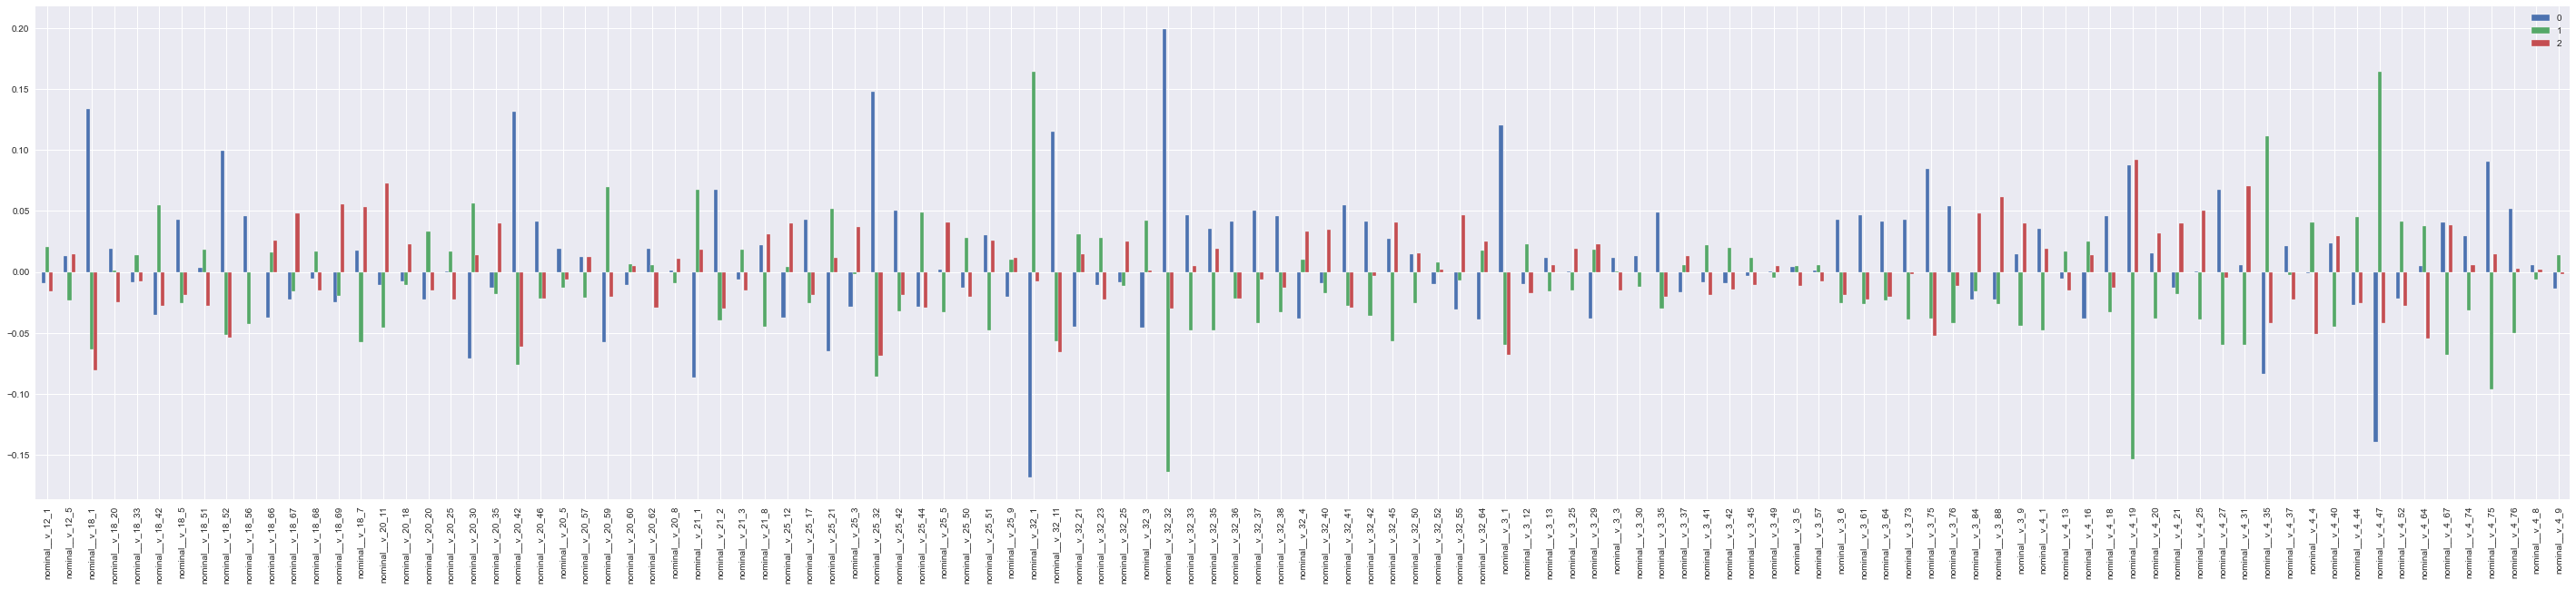

In [64]:
# n1df.loc[:,ch].corrwith(,method='kendall')
def multilabel_correlation(df: pd.DataFrame):
    multilabel_target = pd.get_dummies(target)
    co_0 = df.corrwith(multilabel_target[0], method="kendall")
    # print(f'co_0 min {co_0.var()}')
    # print(f'co_0 max {co_0.max()}')
    co_1 = df.corrwith(multilabel_target[1], method="kendall")
    # print(f'co_1 min {co_1.var()}')
    # print(f'co_1 max {co_1.max()}')
    co_2 = df.corrwith(multilabel_target[2], method="kendall")
    # print(f'co_2 min {co_2.var()}')
    # print(f'co_2 max {co_2.max()}')
    return pd.concat([co_0, co_1, co_2], axis=1)


multilabel_correlation(elite_onf_df).sort_index().plot(
    kind="bar", figsize=(50, 10), backend="matplotlib"
)
multilabel_correlation(n1df).plot(kind="bar")


def multiclass_correlation(df: pd.DataFrame):
    multiclass_target = target
    return df.corrwith(target, method="kendall")

In [361]:
ovr_bag.n_estimators

5

In [ ]:
import plotly.express as px
import plotly.figure_factory as ff

m_info_clf = mutual_info_classif(
    X=n1df, y=target, discrete_features=True, random_state=42
)
f_info = dict(
    zip(
        n1df.columns,
        m_info_clf,
    )
)
micdf = pd.DataFrame(m_info_clf, columns=["M_I_C"], index=n1df.columns)
# px.histogram(micdf,marginal='rug',color_discrete_map=px.colors.sequential.Plasma)
disp = micdf.plot(kind="density", backend="matplotlib")
disp = micdf.plot(kind="hist", backend="matplotlib")

In [ ]:
chi2_f, chi2_p = chi2(X=n1df, y=target)  # ,discrete_features=True,random_state=42)
# f_info = dict(zip(n1df.columns,m_info_clf,))
# px.histogram(data_frame=chi2df,x='p',color='chi2', histnorm='probability

chi2df = pd.DataFrame(np.c_[chi2_f, chi2_p], columns=["chi2", "p"], index=n1df.columns)
# # px.histogram(micdf,marginal='rug',color_discrete_map=px.colors.sequential.Plasma)
# disp = micdf.plot(kind='density',backend='matplotlib')
# disp = micdf.plot(kind='hist',backend='matplotlib')

In [ ]:
chi2df[chi2df.p <= 0.12]

In [ ]:
X_train, X_test, y_train, y_test = train_test(n1df, target, 0.4)

In [ ]:
y_train.value_counts()

In [ ]:
def objective(trial: optuna.trial.Trial):
    rbm_params = {
        "batch_size": trial.suggest_int("rbm_batch_size", 5, 1000),
        "learning_rate": trial.suggest_float("rbm_learning_rate", 1e-03, 1),
        "n_components": trial.suggest_int("rbm_n_components", 3, 336),
        "n_iter": trial.suggest_int("rbm_epoch", 10, 100),
        "random_state": 42,
        "verbose": 0,
    }
    rbm = BernoulliRBM(**rbm_params)

In [20]:
features_selected = {0: [], 1: [], 2: []}
selectors = {0: [], 1: [], 2: []}
feature_selection_df = {0: None, 1: None, 2: None}
feature_performance = {0: None, 1: None, 2: None}
improvements = {0: [], 1: [], 2: []}

In [ ]:
estimator = make_pipeline(
    VarianceThreshold(),
    LogisticRegression(
        solver="liblinear", n_jobs=-1, C=0.03, random_state=2, fit_intercept=False
    ),
)

try:
    idx = 0
    for X, y in tr_nom_db:
        X_train, X_test, y_train, y_test = train_test_split(
            enc_nom_df, y, test_size=0.3, random_state=42
        )
        vt = VarianceThreshold()
        print(f"Shape of data {X_train.shape}")
        __c = vt.fit_transform(X_train)
        print(f"Dim Reduction {X_train.shape[1]-__c.shape[1]}")

        # Baseline
        model = model_clone(estimator)
        model.fit(X_train, y_train)
        acc_init = sklearn.metrics.f1_score(
            model.predict(X_test), y_test, average="micro"
        )
        print(f"baseline f-1 score {acc_init}")
        print(f"Running SFS")
        with parallel_backend("loky"):
            # selector = SequentialFeatureSelector(model_clone(estimator),tol=0.001,n_features_to_select='auto',cv=RepeatedStratifiedKFold(n_splits=3,n_repeats=2),n_jobs=-1,scoring='f1_micro',)
            selector = RFEC(
                model_clone(estimator)[1],
                step=5,
                cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=2),
                n_jobs=-1,
                scoring="f1_micro",
            )
            selector.fit(enc_nom_df, y)
        new_data = selector.transform(enc_nom_df)
        print(f"SFS Dim Reduction {X_train.shape[1]-new_data.shape[1]}")

        X_train, X_test, y_train, y_test = train_test_split(
            new_data, y, test_size=0.3, random_state=42
        )
        model = model_clone(estimator)
        model.fit(X_train, y_train)
        acc_improved = sklearn.metrics.f1_score(
            model.predict(X_test), y_test, average="micro"
        )
        print(f"Improved By {acc_improved - acc_init} on {idx} Label")
        improvements[idx].append(acc_improved - acc_init)
        print(f"New F-1 Score {acc_improved}")
        idx += 1
except KeyboardInterrupt:
    print("Stopped Checking")
    # print(acc_improved)
    print(acc_init)

### Delete Unwanted Categories

In [ ]:
sns.set()
# pd.options.plotting.backend = "matplotlib"
targets = pd.get_dummies(final_data.target)
f_sets_kendall = {}
f_sets_p = {}
for i in range(3):
    g1 = (
        final_data_indvl.drop(["target"], axis=1)
        .astype(np.float64)
        .corrwith(pd.get_dummies(final_data.target)[i], method="kendall")
        .sort_values()
    )
    g2 = g1[(g1 > 0) | (g1 < 0)]
    non_lin, lin = g1[g1 < 0].index, g1[g1 > 0].index
    f_sets_kendall[i] = (non_lin, lin)
    g1 = (
        final_data_indvl.drop(["target"], axis=1)
        .astype(np.float64)
        .corrwith(pd.get_dummies(final_data.target)[i], method="pearson")
        .sort_values()
    )
    g2 = g1[(g1 > 0) | (g1 < 0)]
    non_lin, lin = g1[g1 < 0].index, g1[g1 > 0].index
    f_sets_p[i] = (non_lin, lin)

In [ ]:
for k, v in f_sets_kendall.items():
    nl, l = f_sets_kendall[k]
    print(len(nl), len(l))

In [ ]:
# nd: pd.DataFrame = final_data.loc[:,nominal].astype('float')
# nd.corrwith(final_data.loc[:,binary+ordinal+ratio].astype('float'))
final_data_indvl.corr(method="kendall")

fi_indvl_corr = final_data_indvl.corr(method="kendall")

In [ ]:
# MAX 0.56


# Import Data and One Hot Encode with Drop First
final_data_indvl = pd.get_dummies(
    final_data_indvl, columns=nominal, drop_first=True, sparse=False, dtype=np.float64
)
mean_test_val_clf = defaultdict(list)
# model = NuSVC(nu=0.5,kernel='poly',degree=2,random_state=0)
mem = Memory("../data/tmp/")
for clf in tqdm(classifiers):
    nw_noms = list(
        set(final_data_indvl.columns)
        - set(binary)
        - set(ratio)
        - set(ordinal)
        - {"target"}
    )
    for _i in range(5, 150, 50):
        feature_agglomeration = FeatureAgglomeration(
            n_clusters=_i,
            affinity="euclidean",
            memory=mem,
            compute_full_tree=True,
            linkage="ward",
            compute_distances=True,
        )
        check = feature_agglomeration.fit_transform(
            final_data_indvl.loc[:, nw_noms].astype(np.float64)
        )
        with parallel_backend("loky"):
            # rpt = cross_validate(OneVsOneClassifier(NuSVC(nu=0.5,kernel='poly',degree=4,random_state=0)),check,final_data.target,cv=3,n_jobs=-1)
            try:
                rpt = cross_validate(
                    OneVsOneClassifier(clf),
                    check,
                    final_data.target,
                    cv=3,
                    n_jobs=-1,
                    scoring="f1_micro",
                )
            except:
                continue
            # rpt = cross_validate(OneVsOneClassifier(LogisticRegression(fit_intercept=False,n_jobs=-1,random_state=0)),check,final_data.target,cv=3,n_jobs=-1)
        mean_test_val_clf[clf.__class__.__name__].append(
            (_i, rpt["test_score"].mean(), rpt["test_score"].std())
        )


# sns.set()
# plot_agg_perf()
mean_test_val_clf

In [ ]:
# MAX 0.56


# Pipeline
final_data_indvl = pd.get_dummies(
    final_data_indvl, columns=nominal, drop_first=True, sparse=False, dtype=np.float64
)
nw_noms = list(
    set(final_data_indvl.columns) - set(binary) - set(ratio) - set(ordinal) - {"target"}
)
mem = Memory("../data/tmp3/")
mean_test_val_clf = defaultdict(list)
for clf in tqdm(classifiers):
    pipe = Pipeline(
        steps=[
            ("variancethreshold", VarianceThreshold()),
            ("rfecv", RFE(estimator=clf)),
            (clf.__class__.__name__, clf),
        ]
    )
    with parallel_backend("loky"):
        try:
            rpt = cross_validate(
                OneVsOneClassifier(pipe, n_jobs=-1),
                final_data_indvl.loc[:, nw_noms],
                final_data.target,
                cv=3,
                n_jobs=-1,
                scoring="f1_micro",
            )
        except:
            continue
        # rpt = cross_validate(OneVsOneClassifier(LogisticRegression(fit_intercept=False,n_jobs=-1,random_state=0)),check,final_data.target,cv=3,n_jobs=-1)
    mean_test_val_clf[clf.__class__.__name__].append(
        (rpt["test_score"].mean(), rpt["test_score"].std())
    )
mean_test_val_clf

In [ ]:
def plot_agg_perf(mean_test_val):
    plt.figure(figsize=(10, 5))
    # for i in range(3):
    c, mu, err = zip(*mean_test_val)
    nerr = np.asarray(mu) + -1 * np.asarray(err)
    perr = np.asarray(mu) + np.asarray(err)
    # perr = mu+err
    fi = plt.plot(c, perr)
    fi = plt.plot(c, mu, label=f"Mean Test Score in Label")
    fi = plt.plot(c, nerr)
    plt.fill_between(
        c, perr, nerr, "r", alpha=0.5, color="g", animated=True, cmap="inferno"
    )
    tg = plt.legend(loc="lower right")

In [ ]:
xgb_params = {
    "base_score": None,
    "booster": "gbtree",
    # 'colsample_bylevel': None,
    # 'colsample_bynode': None,
    # 'colsample_bytree': None,
    "gamma": 0,
    # 'gpu_id': None,
    "importance_type": "total_cover",
    # 'interaction_constraints': None,
    "learning_rate": 0.2,
    "eval_metric": "aucpr",
    "max_delta_step": None,
    # 'max_depth': 0,
    "min_child_weight": 1,
    # 'missing': np.nan,
    "monotone_constraints": None,
    "n_estimators": 100,
    # 'updater': 'grow_colmaker',
    "n_jobs": -1,
    "num_parallel_tree": None,
    "random_state": 42,
    "reg_alpha": None,
    "reg_lambda": None,
    "scale_pos_weight": None,
    "subsample": 0.5,
    "tree_method": "approx",
    "use_label_encoder": False,
    "validate_parameters": None,
    "verbosity": 1,
}
h2 = XGBClassifier(n_jobs=-1)


le = LabelEncoder()

# h1.fit(X,y)


# h1 = XGBClassifier(n_estimators=50,random_state=0,max_depth=30,n_jobs=-1,eval_metric='mlogloss')
h1 = XGBClassifier(n_jobs=-1)


fbc = FeatBoostClassifier(
    [
        h1,
        LogisticRegression(
            random_state=43,
            tol=0.00000001,
            max_iter=10000,
            n_jobs=-1,
            fit_intercept=False,
        ),
    ],
    number_of_folds=3,
    max_number_of_features=50,
    metric="f1",
    verbose=2,
    siso_ranking_size=20,
)
# fbc = FeatBoostClassifier(RandomForestClassifier(n_jobs=-1))

In [ ]:
with parallel_backend("loky"):
    fbc.fit(x__, y)

In [ ]:
x__ = final_data_indvl.loc[:, nw_noms].to_numpy()

In [ ]:
tx__ = fbc.transform(x__)

In [ ]:
lcv = LogisticRegressionCV(
    Cs=100,
    fit_intercept=False,
    cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3),
    dual=False,
    penalty="l2",
    scoring="f1_macro",
    solver="lbfgs",
    tol=0.0000000001,
    max_iter=10000,
    # class_weight=None,
    n_jobs=-1,
    verbose=0,
    refit=True,
    # intercept_scaling=1.0,
    multi_class="ovr",
    random_state=42,
    l1_ratios=np.linspace(0.0001, 0.9999, num=10),
)
lcv

In [195]:
medi = medi.loc[:, ["v_29", "v_22", "decimal_values_29", "decimal_values_22"]]

medi_29 = medi.sort_values(by="v_29", axis=0)

medi_29.sort_values(by="v_29", inplace=True)

tempdf = pd.DataFrame()

tempdf["v_29"] = medi_29.v_29 + medi_29.decimal_values_29

tempdf["v_22"] = medi_29.v_22 + medi_29.decimal_values_22

In [140]:
# # ordinal_data.columns

# ordinal_data.v_29 = data.v_29

# ordinal_data.v_22 = data.v_22

# ordinal_data = separate_floating_value(ordinal_data)

# nominal_data = nominal_data.astype(np.uint8)

# nominal_data.info()

In [212]:
# corr_dat = data.corr()
corr_dat.label

v_21    -0.042747
v_32    -0.099336
v_15     0.012123
v_4     -0.019453
v_1     -0.012368
v_8     -0.057983
v_12     0.010495
v_25    -0.076107
v_20    -0.045745
v_18     0.041063
v_3      0.064006
v_11    -0.000913
v_14    -0.005858
v_26    -0.036007
v_27     0.023907
v_30    -0.048670
v_9     -0.001762
v_31    -0.198527
v_28     0.004836
v_13    -0.006180
v_33     0.029574
v_17     0.098969
v_19     0.215180
v_29     0.297882
v_23    -0.019353
v_24    -0.030006
v_10     0.029318
v_5      0.147685
v_6      0.278750
v_22     0.373071
v_0     -0.035275
v_7     -0.041763
v_2     -0.045008
v_16     0.023932
v_34    -0.017565
v_35     0.006083
v_36     0.013118
v_37    -0.004187
v_38    -0.005791
v_39    -0.007229
v_40    -0.003273
label    1.000000
Name: label, dtype: float64

In [57]:
from pyvis.network import Network


adj_list = gen_adj_list(0.9, data=data)


# Adding Nodes
def addfnetnodes(nets, data):
    for c, f in enumerate(data.columns):
        colr = None
        if "nom" in f:
            colr = "#008000"
        elif "ord" in f:
            colr = "#800080"
        elif "bin" in f:
            colr = "#FFEC00"
        elif "label" in f:
            colr = "#D800FF"
        else:
            colr = "#FF0083"
        nets.add_node(c, label=f, shape="circle", color=colr)
    return nets


def addfnetedges(nt: Network, nnli):
    global adj_list
    corr_mat = data.corr()
    for nd in adj_list:
        if len(adj_list[nd]) > 0:
            for conn in adj_list[nd]:
                nt.add_edge(nnli[nd], nnli[conn], weight=corr_mat.loc[nd, conn])
    return nt


def draw_feature_network():
    global data, adj_list
    fnet = Network(
        notebook=False,
        heading="Clustering of Features",
        height="1080px",
        width="2000px",
        font_color="#46ff00",
        bgcolor="#9ed6c8",
    )
    fnet = addfnetnodes(fnet, data)
    nnli = {f["label"]: f["id"] for f in fnet.nodes}  #  net_node_label_ids
    fnet = addfnetedges(fnet, nnli)
    fnet.toggle_physics(True)
    fnet.set_options(
        """
        const options = {
        "edges": {
        "color": {
          "inherit": true
        },
        "selfReferenceSize": null,
        "selfReference": {
          "angle": 0.7853981633974483,
          "renderBehindTheNode": false
        },
        "smooth": {
          "type": "vertical",
          "forceDirection": "vertical"
        }
        },
        "interaction": {
        "hover": true,
        "multiselect": true,
        "navigationButtons": true
        },
        "manipulation": {
        "enabled": true,
        "initiallyActive": true
        },
        "physics": {
        "hierarchicalRepulsion": {
          "centralGravity": 0,
          "springLength": 440,
          "springConstant": 0,
          "nodeDistance": 90,
          "damping": 1,
          "avoidOverlap": 0.46
        },
        "maxVelocity": 1,
        "minVelocity": 0.01,
        "solver": "hierarchicalRepulsion",
        "timestep": 0.54,
        "wind": {
          "x": 0
        }
        }
        }
        """
    )
    return fnet

In [197]:
binary_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3796 entries, 0 to 3795
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   v_1     3796 non-null   int64
 1   v_26    3796 non-null   int64
 2   v_11    3796 non-null   int64
 3   v_14    3796 non-null   int64
 4   v_30    3796 non-null   int64
 5   v_28    3796 non-null   int64
 6   v_9     3796 non-null   int64
 7   v_27    3796 non-null   int64
dtypes: int64(8)
memory usage: 266.9 KB


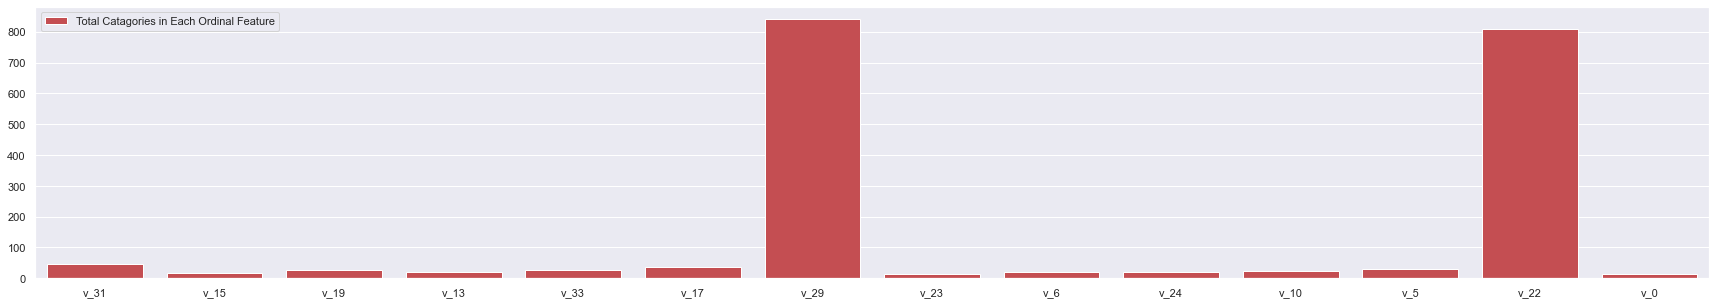

In [ ]:
categorical = ordinal + nominal
oridinal_categories_total = {}
for c in ordinal:
    # print(c, len(data[c].unique()))
    oridinal_categories_total[c] = len(data[c].unique())
fig = plt.figure(figsize=(30, 5))

fig = sns.barplot(
    x=ordinal,
    saturation=1,
    y=list(oridinal_categories_total.values()),
    label="Total Catagories in Each Ordinal Feature",
    color="r",
)
plt.legend()
# plt.table(ordinal)
plt.shor()

##### After Removing the decimal Part from the features

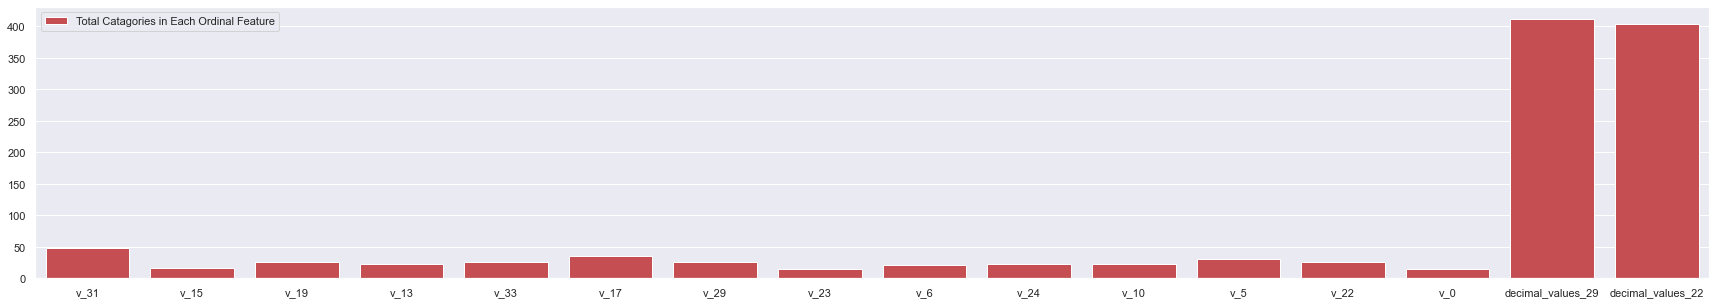

In [ ]:
categorical = ordinal + nominal
oridinal_categories_total = {}
for c in ordinal_data.columns:
    # print(c, len(data[c].unique()))
    oridinal_categories_total[c] = len(ordinal_data[c].unique())
fig = plt.figure(figsize=(30, 5))

fig = sns.barplot(
    x=ordinal_data.columns,
    saturation=1,
    y=list(oridinal_categories_total.values()),
    label="Total Catagories in Each Ordinal Feature",
    color="r",
)
# plt.table(ordinal)
# fig = plt.title
plt.xlabel = "After CLeanup"
fig = plt.legend()
fig = plt.show()

In [ ]:
# pd
temp = pd.DataFrame(
    oridinal_categories_total, columns=oridinal_categories_total.keys(), index=["count"]
)
temp.style

,v_31,v_15,v_19,v_13,v_33,v_17,v_29,v_23,v_6,v_24,v_10,v_5,v_22,v_0,decimal_values_29,decimal_values_22
count,48,17,26,22,26,36,26,14,21,22,23,30,26,15,411,403


In [ ]:
for c in ordinal_data.columns:
    if "decimal" not in c:
        ordinal_data[c] = ordinal_data[c].astype(np.uint8)

In [ ]:
# def print_num_cat(dd):
    for c in dd.columns:
        print(c,"\t|\t", len(dd[c].unique()))
        print("-"*30)

print("Binary")
print_num_cat(binary_data)
# print("-"*30)
print("\n"*4)

print("Nominal")
print_num_cat(nominal_data)
print("\n"*4)
print("Ordinal")
print_num_cat(ordinal_data)

In [ ]:
ordinal_data.decimal_values_22[ordinal_data.decimal_values_22! = 0].shape

(2496,)

In [ ]:
fig = plt.figure(figsize=(30, 10))

hm = sns.heatmap(data.corr())

In [ ]:
corr_mat = data.corr()

In [ ]:
training_target = data.label
df = data.drop(["label"], axis=1)
# len(df.columns)
corr_mat

In [196]:
ordinal_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3796 entries, 0 to 3795
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   v_31               3796 non-null   uint8  
 1   v_15               3796 non-null   uint8  
 2   v_19               3796 non-null   uint8  
 3   v_13               3796 non-null   uint8  
 4   v_33               3796 non-null   uint8  
 5   v_17               3796 non-null   uint8  
 6   v_29               3796 non-null   uint8  
 7   v_23               3796 non-null   uint8  
 8   v_6                3796 non-null   uint8  
 9   v_24               3796 non-null   uint8  
 10  v_10               3796 non-null   uint8  
 11  v_5                3796 non-null   uint8  
 12  v_22               3796 non-null   uint8  
 13  v_0                3796 non-null   uint8  
 14  decimal_values_29  3796 non-null   float64
 15  decimal_values_22  3796 non-null   float64
dtypes: float64(2), uint8(14)

In [178]:
# for c in ordinal+nominal:
#     data[c] = data[c].astype('category')
# Too soon

### Delete Unwanted Categories

In [68]:
# data_ = pd.read_csv('../data/train.csv',index_col=0)